# 1.Determinen la función de transferencia del circuito para una frecuencia de 80 Hz y una amplitud de 100 mV.
- Recuerden elegir un filtro adecuado y esperar el tiempo de asentamiento entre el cambio de algún parámetro y la determinación del valor.
- ¿Cómo le asignarían una incertidumbre a la medición? ¿Como reducirían esaincertidumbre?

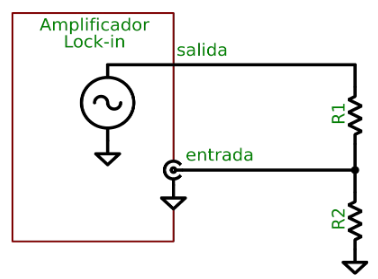

Lo primero que queremos hacer es settear la señal de referencia (de modulación) del lock-in, para eso vamos a necesitar pasarle los siguientes comandos al dispositivo:
- PHAS 0   -> Le dice al lock-in que la fase de la señal de referencia es 0. Después hay que hacerlo de vuelta con 90.
- FMOD 1   -> Le dice al lock-in que la señal de referencia es interna (generada por el mismo aparato)
- FREQ 80  -> Le dice al lock-in que la frecuencia de la señal de referencia es de 80Hz
- SLVL 0.1 -> Le dice al lock-in que la amplitud de la señal de referencia es de 0.1V

Despues, necesitamos decirle que canal queremos medir:
- ISRC 0 -> Le dice al lock-in que mida voltaje diferencial (1) o single-ended (0), nosotros necesitamos single ended porque al canal 2 no hay nada conectado

Despues, tenemos que settear la sensibilidad del medidor y los parámetros del filtro:
- SENS 24 -> Le dice al lock-in que ponga la escala de voltajes en 200mV
- OFLT 7  -> Le dice al lock-in que la frecuencia de corte sea $f = \frac{1}{ \tau}$ donde para el valor 7, $\tau = 30ms \implies f \approx 33.3Hz$
- OFSL 0  -> Le dice al lock-in que el orden del filtro sea 6 (?

Después le tenemos que decir que es lo que queremos que nos "muestre" en la pantalla:
- DDEF 1, 1 -> Le dice al lock-in que en el canal 1 muestre R
- DDEF 2, 1 -> Le dice al lock-in que en el canal 2 muestre $\theta$

Después, le decimos de que forma se comunica con la computadora:
- OUTX 1 -> Le dice al lock-in que la salida va a ser por GPIB

Para que estos comandos sean mas fáciles de pasar al lock-in, Marce y Nico hicieron una clase de python que se llama SR830. Cuando creamos un objeto de esta clase le tenemos que pasar un diccionario con la configuración que queremos que tenga el lock-in y el objeto ya tiene los métodos programados para medir y hacer otras funciones útiles. El formato de la configuración que hay que pasarle es un diccionario de python y es el siguiente:

config = {\
          'lockin_addr': str,\
          'medicion_modo' : int,\
          'display_modo' : str,\
          'sens' : int,\
          'slope' : int,\
          't_int' : int,\
          'ref_intern' : bool,\
          'ref_freq' : int,\
          'ref_v' : int,\
          }
          
La razón de los parámetros es la siguiente:
- lockin_addr -> Acá se debe pasar el puerto en el que está conectado el lock-in, en nuestro caso queremos que sea 'GPIB0::11::INSTR'
- medicion_modo -> Es análogo al comando ISRC: Selecciona el canal del osciloscopio en el que queremos medir, en nuestro caso es 0 (single ended)
- display_modo -> Es análogo al comando DDEF: Hace que al medir el lock-in nos devuelva R y $\theta$ o X e Y, en nuestro caso queremos que display_modo sea "RT" para que muestre R y $\theta$
- sens -> Es análogo al comando SENS: Setea la escala del lock-in. Este prámetro hay que ir variandolo hasta encontrar un valor que funcione, hay que fijarse los valores disponibles en el manual, página 90
- slope -> Es análogo al comando OFSL: Setea el orden del filtro, también hay que ir probando con los valores que dice el manual en la página 90
- t_int -> Es análogo al comando OFLT: Setea la frecuencia de corte, también hay que ir probando con los valroes que dice el manual en la página 90
- ref_intern -> Es análogo al comando FMOD: Le dice al lock-in si él mismo genera la señal o estamos usando un generador de funciones aparte, en nuestro caso queremos que sea TRUE
- ref_freq -> Es análogo al comando FREQ: Le dice al lock-in la frecuencia de la señal de referencia, en nuestro caso queremos que sea 80 (Hz).
- ref_v -> Es análogo al comando SLVL: Le dice al lock-in la amplitud de la señal de referencia, en nuestro caso queremos que sea 0.1 (V).

Entonces empezamos con el código. Lo primero que podemos hacer es asegurarnos de tener el puerto correcto; para eso importamos visa y le preguntamos cuales son los puertos disponibles, después vemos si el GPIB es el instrumento que queremos: 

In [ ]:
import visa

rm = visa.ResourceManager()

print(rm.list_resoruces()) #Preguntamos los puertos

#Vemos que devuelve el puerto "GPIB0::11::INSTR" que es el que queremos, pero aún así lo chequeamos

inst = rm.open_resource("GPIB0::11::INSTR") #Inicializamos comunicación con ese puerto
print(inst.query("*IDN?")) #Le preguntamos que instrumento esta conectado al puerto

#Debería devolver que es el lock-in SR830

Ahora inicializamos un objeto de la clase SR830 para configurar lo que queremos medir

In [ ]:
from lockin import SR830

config = {
          'lockin_addr': 'GPIB0::11::INSTR', 
          'medicion_modo' : 0, #Canal A single-ended
          'display_modo' : 'RT', #Nos muestra R y Tita
          'sens' : 21, #Sensibilidad 20mV
          'slope' : 0, #Orden del filtro 6dB/oct
          't_int' : 8, #Frecuencia de corte 10Hz 
          'ref_intern' : True, #Él mismo genera la referencia
          'ref_freq' : 80, #Con frecuencia 80Hz
          'ref_v' : 0.1, #Con amplitud 0.1V
          }

lock = SR830(config)

Genial, ya está todo listo para medir!
Ahora podemos usar los otros métodos de la clase SR830: 
- lock.getDisplay() -> Nos devuelve dos números, el primero dice qué muestra el display del canal 1 y el otro el del canal 2
- lock.getMedicion("RT" o "XY") -> Según cual sea la configuración que le pasemos, nos devuelve el valor de R y Tita o de X e Y

Entonces vamos a ver que medimos para las sensibilidades que seteamos:

In [ ]:
print(lock.getMedicion("RT"))

Definimos una función para medir y que printee lo que medimos usando el método getMedicion del lock in:

In [ ]:
def medir(lock):
    R, tita = lock.getMedicion("RT")
    print(f"R (amplitud) tiene un valor de {R}Volts\ntita tiene un valor de {tita}")
    return [R, tita]

Ahora veamos esto para distintas sensibilidades y distintas frecuencias de corte a ver que da: 

In [ ]:
import numpy as np
from time import sleep
from time import time

freqs_corte = np.arange(2, 15, 1, dtype=int) #Estas son las frecuencias de corte entre 10kHz y 0.01Hz
sens = np.arange(8, 24, 1, dtype=int) #Estas son las sensibilidades que van de 1microV a 100mV
Rs = [] #Al final van a quedar en cada columna una frecuencia distinta y en cada fila una sensibilidad distinta
titas = [] #Lo mismo con este array

lockin.setFilterSlope(3) #Seteamos el orden del filtro al máximo (se puede cambiar, hay que probar)

for ii, sen in enumerate(sens):
    Rs_fil = []
    titas_fil = []
    for jj, freq in enumerate(freqs_corte):
        lock.setSensibility(sen)
        lock.setIntegrationTime(freq)
        R, tita = medir(lock)
        Rs_fil.append(R)
        titas_fil.append(tita)
        sleep(0.2)
    Rs.append(Rs_fil)
    titas.append(titas_fil)

#Guardamos los datos 
Rs = np.array(Rs)
titas = np.array(titas)
np.savetxt("R_frecs_y_sens.txt", Rs, delimiter=",")
np.savetxt("titas_frecs_y_sens.txt", titas, delimiter=",")

Ahora visualizamos distintas mediciones para ver qué parámetros son mejores

In [ ]:
import matplotlib.pyplot as plt

R_plot = Rs[11,:] #Esto elige que sensibilidad y que frecuencia de corte ver
plt.plot(R_plot, '.b')
plt.yscale("log")
plt.grid()
plt.show()

Ahora para la frecuencia y la sensibilidad que nos parece que es mejor para medir tomamos varias mediciones para despues tomar el promedio

In [ ]:
frec = 8 #Frecuencia deseada
sens = 12 #Sensibilidad deseada
lock.setSensibility(sens) 
lock.setIntegrationTime(frec)
Rs = []
titas = []
sleep(3)

#Medimos para 100 datos
for ii, med in enumerate(range(100)):
    R, tita = lock.getMedicion("RT")
    Rs.append(R)
    titas.append(tita)
    sleep(0.1)

plt.plot(Rs,'.r')

#Guardamos los datos. Esta vez es un vector
np.savetxt(f"R_f{frec}_s{sens}.txt", Rs, delimiter=",")
np.savetxt(f"tita_f{frec}_s{sens}.txt", titas, delimiter=",")

#estamos midiendo la salida, no la tranferencia, para 
#esto hay q dividir por 0.1 y probablemente multiplicar 
#por 2 ( por como funciona el lock-in)